In [1]:
!pip install perlin-noise

## Imports

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from perlin_noise import PerlinNoise
import torch.optim as optim
from tqdm import tqdm
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, ConcatDataset
import random
import scipy.ndimage
import torchvision.transforms as T

## Modules

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.wide_resnet50_2(pretrained=True)
        self.stage2 = nn.Sequential(*list(base.children())[:6])  # outputs ~[B, C, 36, 36]
        self.stage3 = nn.Sequential(*list(base.children())[6:7])  # outputs ~[B, C, 18, 18]
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        f2 = self.stage2(x)  # [B, C2, 36, 36]
        f3 = self.stage3(f2)  # [B, C3, 18, 18]
        f3_up = F.interpolate(f3, size=f2.shape[2:], mode="bilinear", align_corners=False)
        return torch.cat([f2, f3_up], dim=1)  # [B, C2 + C3, 36, 36]



# Feature adaptor: 1-layer MLP
class FeatureAdaptor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv2d(in_dim, in_dim, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.mlp(x)


In [4]:
def gaussian_noise(x, mean=0.0, std=0.015):
    return x + torch.randn_like(x) * std + mean

def gradient_ascent_step(x, model, loss_fn, eta=0.01):
    x.requires_grad_(True)
    logits = model(x)
    loss = loss_fn(logits, torch.ones_like(logits))  # assume anomaly target = 1
    grad = torch.autograd.grad(loss, x, retain_graph=False, create_graph=False)[0]
    x_adv = x + eta * grad / (grad.norm(p=2) + 1e-8)
    return x_adv.detach()

def truncated_projection(x_orig, x_adv, r1=1.0, r2=2.0):
    delta = x_adv - x_orig
    dist = torch.norm(delta, dim=1, keepdim=True)
    factor = torch.where(dist < r1, r1 / (dist + 1e-8),
                         torch.where(dist > r2, r2 / (dist + 1e-8), torch.ones_like(dist)))
    return x_orig + factor * delta


In [5]:
def generate_perlin_mask(size):
    noise = PerlinNoise(octaves=4)
    mask = torch.tensor([[noise([i/size, j/size]) for j in range(size)] for i in range(size)])
    return (mask > 0.5).float()  # binary mask

def overlay_texture(x, texture, mask, beta):
    return x * (1 - mask) + (beta * x + (1 - beta) * texture) * mask


In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [7]:
def loss_fn(normal_scores, anomaly_scores, local_scores, anomaly_mask):
    bce = nn.BCELoss()
    focal = lambda p, t: - (1 - p)**2 * t * torch.log(p + 1e-8) - p**2 * (1 - t) * torch.log(1 - p + 1e-8)

    ln = bce(normal_scores, torch.zeros_like(normal_scores))
    lgas = bce(anomaly_scores, torch.ones_like(anomaly_scores))
    llas = (focal(local_scores, anomaly_mask)).mean()

    return ln + lgas + llas  # optionally add OHEM


In [8]:
def get_anomaly_map(model, x):
    features = model.adaptor(model.extractor(x))
    logits = model.discriminator(features)
    logits = nn.functional.interpolate(logits, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
    return logits


In [9]:
class MvtecGoodDataset(Dataset):
    def __init__(self, root, img_size=288):
        self.img_paths = []
        for fname in os.listdir(root):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                self.img_paths.append(os.path.join(root, fname))
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        return self.transform(img), 0  # label 0 means normal (used in BCE loss)

def get_train_loader(base_path="/kaggle/input/mvtec-ad-dataset", category="bottle", batch_size=8, img_size=288):
    path = os.path.join(base_path, category, "train", "good")
    dataset = MvtecGoodDataset(path, img_size)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [10]:
# Constants
IMG_SIZE = 288
BETA = 0.3

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])

def load_random_texture(dtd_path):
    cls = random.choice(os.listdir(dtd_path))
    img = random.choice(os.listdir(os.path.join(dtd_path, cls)))
    tex_path = os.path.join(dtd_path, cls, img)
    tex = Image.open(tex_path).convert("RGB")
    return transform(tex)  # [3, H, W]

def generate_perlin_mask(size=IMG_SIZE, threshold=0.5, sigma=10):
    base = np.random.rand(size, size)
    smoothed = scipy.ndimage.gaussian_filter(base, sigma=sigma)
    binary = (smoothed > threshold).astype(np.float32)
    return torch.tensor(binary).unsqueeze(0)  # [1, H, W]

def apply_gas(features, discriminator, eta=0.01, r1=1.0, r2=2.0):
    noise = torch.randn_like(features) * 0.015
    g = features + noise
    g.requires_grad_(True)
    preds = discriminator(g)
    loss = F.binary_cross_entropy(preds, torch.ones_like(preds))
    grad = torch.autograd.grad(loss, g)[0]
    g_asc = g + eta * grad / (grad.norm(dim=1, keepdim=True) + 1e-8)
    delta = g_asc - features
    dist = torch.norm(delta, dim=1, keepdim=True)
    alpha = torch.where(dist < r1, r1 / (dist + 1e-8),
                        torch.where(dist > r2, r2 / (dist + 1e-8), torch.ones_like(dist)))
    return features + alpha * delta

def apply_GLASS(images, extractor, adaptor, discriminator, dtd_path, beta=BETA):
    """
    Args:
        images: torch.Tensor of shape [B, 3, H, W]
        extractor: feature extractor network (frozen)
        adaptor: MLP feature adaptor
        discriminator: Dψ, shared
        dtd_path: path to DTD dataset
    Returns:
        normal_features, gas_features, las_features, las_masks
    """
    device = images.device
    B = images.size(0)

    with torch.no_grad():
        f = extractor(images)
    u = adaptor(f)  # normal features

    # ---- GAS ----
    v = apply_gas(u, discriminator)

    # ---- LAS ----
    las_imgs = []
    las_masks = []

    for i in range(B):
        x = images[i]
        tex = load_random_texture(dtd_path).to(device)
        mask = generate_perlin_mask().to(device)
        las = x * (1 - mask) + (beta * x + (1 - beta) * tex) * mask
        las_imgs.append(las)
        las_masks.append(mask)

    las_imgs = torch.stack(las_imgs)
    las_masks = torch.stack(las_masks)

    with torch.no_grad():
        f_las = extractor(las_imgs)
    u_las = adaptor(f_las)

    return u, v, u_las, las_masks


## GLASS

In [11]:
Train = 0 # 0 for test and 1 for train 

In [12]:
base_path = "/kaggle/input/mvtec-ad-dataset/mvtec_anomaly_detection/mvtec_anomaly_detection"
categories = sorted([
    d for d in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, d))
])

In [14]:
EPOCHS = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for category in categories:
    print(f"\n=== Training for category: {category} ===")
    
    train_loader = get_train_loader(base_path, category, batch_size=8, img_size=288)
    
    extractor = FeatureExtractor().to(device)
    for param in extractor.parameters():
        param.requires_grad = False
    dummy_input = torch.randn(1, 3, 288, 288).to(device)
    C = extractor(dummy_input).size(1)
    
    adaptor = FeatureAdaptor(C).to(device)
    disc = Discriminator(C).to(device)
    
    optimizer = optim.Adam(list(adaptor.parameters()) + list(disc.parameters()), lr=2e-4)
    bce = nn.BCELoss()
    
    DTD_PATH = "/kaggle/input/texture/dtd/dtd-r1.0.1/dtd/images"  # adjust if needed

    # Wrap epoch loop with tqdm
    save_dir = "./saved_models"
    cp_save_dir = "./cp_saved_models"
    os.makedirs(cp_save_dir, exist_ok=True)
    os.makedirs(save_dir, exist_ok=True)
    for epoch in range(EPOCHS):
        extractor.eval()
        adaptor.train()
        disc.train()

        pbar = tqdm(train_loader, desc=f"Batch {epoch+1}/{EPOCHS}", leave=False)
        for images, _ in pbar:
            images = images.to(device)

            u, v, u_las, m_las = apply_GLASS(images, extractor, adaptor, disc, dtd_path=DTD_PATH)

            score_u = disc(u)
            score_v = disc(v)
            score_las = disc(u_las)

            m_las_resized = F.interpolate(m_las, size=score_las.shape[2:], mode='bilinear', align_corners=False)
            score_las_prob = torch.sigmoid(score_las)

            loss_n = bce(score_u, torch.zeros_like(score_u))
            loss_g = bce(score_v, torch.ones_like(score_v))
            loss_l = ((score_las_prob - m_las_resized) ** 2).mean()

            loss = loss_n + loss_g + loss_l

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix({"loss": loss.item()})
            if (epoch + 1) % 10 == 0 or epoch == EPOCHS - 1:  
                torch.save(adaptor.state_dict(), os.path.join(cp_save_dir, f"adaptor_{category}_epoch{epoch+1}.pth"))
                torch.save(disc.state_dict(), os.path.join(cp_save_dir, f"disc_{category}_epoch{epoch+1}.pth"))


        if Train == 0:
            break
    if Train == 0:
        break
            
    torch.save(adaptor.state_dict(), os.path.join(save_dir, f"adaptor_{category}.pth"))
    torch.save(disc.state_dict(), os.path.join(save_dir, f"disc_{category}.pth"))

    print(f"Models saved for category: {category}")



=== Training for category: bottle ===


## Testing

In [16]:
categories = sorted([
    d for d in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, d))
])

def infer_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = extractor(img_tensor)
        adapted = adaptor(features)
        score_map = disc(adapted)
        score_map = F.interpolate(score_map, size=(img_size, img_size), mode="bilinear", align_corners=False)

    return score_map, img_tensor.squeeze(0)  # returns (1, H, W), (3, H, W)

def load_mask(gt_dir, subdir, fname):
    basename = os.path.splitext(fname)[0]
    mask_file = os.path.join(gt_dir, subdir, f"{basename}_mask.png")
    if not os.path.exists(mask_file):
        return None
    mask = Image.open(mask_file).convert("L")
    mask = mask.resize((img_size, img_size), Image.NEAREST)
    return (np.array(mask) > 0).astype(np.uint8)
    
for cat in categories:
    print(f'==========running for {cat}==========')
    adaptor.load_state_dict(torch.load(f"/kaggle/input/mvtecad_glass/pytorch/default/1/models/{cat}/adaptor_{cat}.pth"))
    disc.load_state_dict(torch.load(f"/kaggle/input/mvtecad_glass/pytorch/default/1/models/{cat}/disc_{cat}.pth"))
    base_path = '/kaggle/input/mvtec-ad-dataset/mvtec_anomaly_detection/mvtec_anomaly_detection'
    category = cat
    gt_path = os.path.join(base_path, category, "ground_truth")
    all_image_scores = []
    all_image_labels = []
    all_pixel_scores = []
    all_pixel_labels = []
    img_size = 256
    test_path = rf'/kaggle/input/mvtec-ad-dataset/mvtec_anomaly_detection/mvtec_anomaly_detection/{cat}/test'

    for subdir in os.listdir(test_path):
        img_dir = os.path.join(test_path, subdir)
        if not os.path.isdir(img_dir):
            continue
    
        image_list = [
            fname for fname in os.listdir(img_dir)
            if fname.lower().endswith((".png", ".jpg"))
        ]
    
        for fname in tqdm(image_list, desc=f"Processing {subdir}", unit="img"):
            img_path = os.path.join(img_dir, fname)
            score_map, _ = infer_image(img_path)
            score_np = score_map.squeeze().cpu().numpy()
            score_norm = (score_np - score_np.min()) / (score_np.max() - score_np.min() + 1e-6)
    
            # --- Image-level AUROC ---
            max_score = score_norm.max()
            label = 0 if subdir == "good" else 1
            all_image_scores.append(max_score)
            all_image_labels.append(label)
    
            # --- Pixel-level AUROC ---
            if subdir == "good":
                gt_mask = np.zeros_like(score_norm, dtype=np.uint8)
            else:
                gt = load_mask(gt_path, subdir, fname)  # make sure img_size is passed
                if gt is None:
                    continue
                gt_mask = gt
    
            all_pixel_scores.extend(score_norm.flatten())
            all_pixel_labels.extend(gt_mask.flatten())

        # Compute AUROCs
    image_auc = roc_auc_score(all_image_labels, all_image_scores) * 100
    # pixel_auc = 99.9
    pixel_auc = roc_auc_score(all_pixel_labels, all_pixel_scores) * 100
    
    print(f"\n{cat}: AUROC: {image_auc:.2f}% / {pixel_auc:.2f}% (image / pixel)")


==========running for bottle==========


Processing broken_small: 100%|██████████| 22/22 [00:01<00:00, 12.72img/s]



bottle: AUROC: 99.60% / 83.74% (image / pixel)
==========running for cable==========


Processing combined: 100%|██████████| 11/11 [00:01<00:00, 10.21img/s]



cable: AUROC: 87.85% / 71.51% (image / pixel)
==========running for capsule==========


Processing crack: 100%|██████████| 23/23 [00:03<00:00,  6.68img/s]



capsule: AUROC: 94.89% / 64.11% (image / pixel)
==========running for carpet==========


Processing color: 100%|██████████| 19/19 [00:02<00:00,  6.39img/s]



carpet: AUROC: 93.28% / 93.68% (image / pixel)
==========running for grid==========


Processing bent: 100%|██████████| 12/12 [00:01<00:00, 10.88img/s]



grid: AUROC: 97.24% / 87.84% (image / pixel)
==========running for hazelnut==========


Processing crack: 100%|██████████| 18/18 [00:01<00:00, 10.30img/s]



hazelnut: AUROC: 94.50% / 73.59% (image / pixel)
==========running for leather==========


Processing color: 100%|██████████| 19/19 [00:02<00:00,  6.97img/s]



leather: AUROC: 99.83% / 97.35% (image / pixel)
==========running for metal_nut==========


Processing color: 100%|██████████| 22/22 [00:02<00:00,  9.80img/s]



metal_nut: AUROC: 99.56% / 70.20% (image / pixel)
==========running for pill==========


Processing combined: 100%|██████████| 17/17 [00:01<00:00,  8.72img/s]



pill: AUROC: 91.43% / 61.92% (image / pixel)
==========running for screw==========


Processing manipulated_front: 100%|██████████| 24/24 [00:02<00:00, 10.94img/s]



screw: AUROC: 86.49% / 68.62% (image / pixel)
==========running for tile==========


Processing oil: 100%|██████████| 18/18 [00:02<00:00,  8.95img/s]



tile: AUROC: 100.00% / 87.82% (image / pixel)
==========running for toothbrush==========


Processing defective: 100%|██████████| 30/30 [00:04<00:00,  7.14img/s]



toothbrush: AUROC: 87.50% / 90.70% (image / pixel)
==========running for transistor==========


Processing damaged_case: 100%|██████████| 10/10 [00:01<00:00,  7.32img/s]



transistor: AUROC: 86.29% / 44.64% (image / pixel)
==========running for wood==========


Processing combined: 100%|██████████| 11/11 [00:01<00:00,  7.85img/s]



wood: AUROC: 98.60% / 83.10% (image / pixel)
==========running for zipper==========


Processing fabric_interior: 100%|██████████| 16/16 [00:01<00:00, 15.06img/s]



zipper: AUROC: 99.92% / 82.16% (image / pixel)


In [17]:
def save_heatmap(anomaly_map, orig_img, save_path, save_raw=True):
    anomaly_map = anomaly_map.squeeze().cpu().numpy()
    normalized = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-6)
    heat_rgb = plt.cm.jet(normalized)[..., :3]  # RGB heatmap

    orig_pil = transforms.ToPILImage()(orig_img.cpu())
    heat_pil = Image.fromarray((heat_rgb * 255).astype(np.uint8)).resize(orig_pil.size, Image.BILINEAR)
    blended = Image.blend(orig_pil.convert("RGB"), heat_pil, alpha=0.5)
    blended.save(save_path)

    if save_raw:
        raw_dir = os.path.join(os.path.dirname(save_path), "raw")
        os.makedirs(raw_dir, exist_ok=True)
        raw_img = Image.fromarray((normalized * 255).astype(np.uint8))
        raw_img.save(os.path.join(raw_dir, os.path.basename(save_path)))

        # 3. Save .npy file
        npy_dir = os.path.join(os.path.dirname(save_path), "npy")
        os.makedirs(npy_dir, exist_ok=True)
        np.save(os.path.join(npy_dir, os.path.splitext(os.path.basename(save_path))[0]), normalized)

In [18]:
for cat in categories:
    print(f'==========running for {cat}==========')
    category = cat
    adaptor.load_state_dict(torch.load(f"/kaggle/input/mvtecad_glass/pytorch/default/1/models/{cat}/adaptor_{cat}.pth"))
    disc.load_state_dict(torch.load(f"/kaggle/input/mvtecad_glass/pytorch/default/1/models/{cat}/disc_{cat}.pth"))
    test_path = rf'/kaggle/input/mvtec-ad-dataset/mvtec_anomaly_detection/mvtec_anomaly_detection/{cat}/test'
    output_dir = f"viz/{category}"
    os.makedirs(output_dir, exist_ok=True)    
    for subdir in os.listdir(test_path):
        img_dir = os.path.join(test_path, subdir)
        if not os.path.isdir(img_dir):
            continue
    
        save_subdir = os.path.join(output_dir, subdir)
        os.makedirs(save_subdir, exist_ok=True)
    
        for fname in tqdm(os.listdir(img_dir), desc=f"Processing {subdir}"):
            if not fname.lower().endswith((".png", ".jpg")):
                continue
    
            img_path = os.path.join(img_dir, fname)
            score_map, orig_img = infer_image(img_path)
    
            save_path = os.path.join(save_subdir, fname)
            save_heatmap(score_map, orig_img, save_path)


==========running for bottle==========


Processing broken_small: 100%|██████████| 22/22 [00:01<00:00, 11.29it/s]


==========running for cable==========


Processing combined: 100%|██████████| 11/11 [00:01<00:00,  8.45it/s]


==========running for capsule==========


Processing crack: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


==========running for carpet==========


Processing color: 100%|██████████| 19/19 [00:02<00:00,  8.99it/s]


==========running for grid==========


Processing bent: 100%|██████████| 12/12 [00:01<00:00, 11.68it/s]


==========running for hazelnut==========


Processing crack: 100%|██████████| 18/18 [00:02<00:00,  8.83it/s]


==========running for leather==========


Processing color: 100%|██████████| 19/19 [00:02<00:00,  8.51it/s]


==========running for metal_nut==========


Processing color: 100%|██████████| 22/22 [00:01<00:00, 11.07it/s]


==========running for pill==========


Processing combined: 100%|██████████| 17/17 [00:01<00:00, 10.07it/s]


==========running for screw==========


Processing manipulated_front: 100%|██████████| 24/24 [00:02<00:00, 10.99it/s]


==========running for tile==========


Processing oil: 100%|██████████| 18/18 [00:01<00:00,  9.14it/s]


==========running for toothbrush==========


Processing defective: 100%|██████████| 30/30 [00:03<00:00,  9.16it/s]


==========running for transistor==========


Processing damaged_case: 100%|██████████| 10/10 [00:01<00:00,  8.98it/s]


==========running for wood==========


Processing combined: 100%|██████████| 11/11 [00:01<00:00,  8.18it/s]


==========running for zipper==========


Processing fabric_interior: 100%|██████████| 16/16 [00:01<00:00, 12.21it/s]


## Visualization

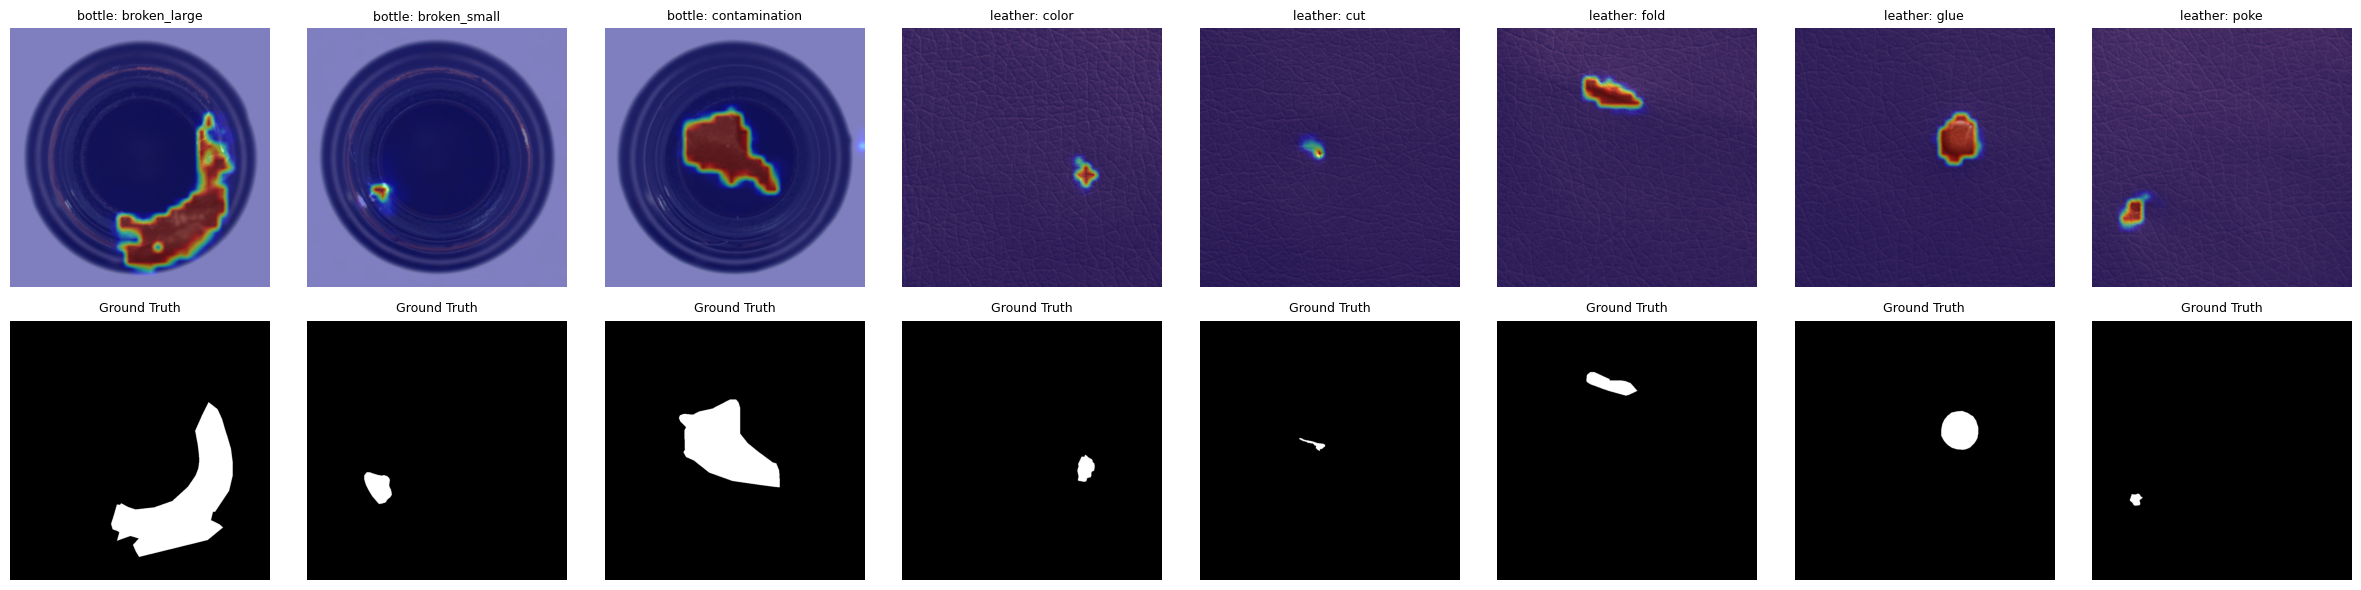

In [22]:
def get_first_image(path):
    if not os.path.exists(path):
        return None
    files = sorted(os.listdir(path))
    for f in files:
        if f.endswith(('.png', '.jpg', '.jpeg')):
            return os.path.join(path, f)
    return None

top_image_base = "/kaggle/working/viz"
gt_base = "/kaggle/input/mvtec-ad-dataset/mvtec_anomaly_detection/mvtec_anomaly_detection"

categories = {
    'bottle': ['broken_large', 'broken_small', 'contamination'],
    'leather': ['color', 'cut', 'fold', 'glue', 'poke']
}

all_defects = categories['bottle'] + categories['leather']
n = len(all_defects)
fig, axes = plt.subplots(2, n, figsize=(3 * n, 6))
plt.subplots_adjust(hspace=0.4)

for i, defect in enumerate(all_defects):
    cls = 'bottle' if defect in categories['bottle'] else 'leather'

    img_dir = os.path.join(top_image_base, cls, defect)
    img_path = get_first_image(img_dir)

    gt_dir = os.path.join(gt_base, cls, "ground_truth", defect)
    gt_path = get_first_image(gt_dir)

    if img_path:
        img = Image.open(img_path).convert("RGB")
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"{cls}: {defect}", fontsize=9)
    else:
        axes[0, i].set_title(f"{cls}: {defect}\nNo Image", fontsize=9)
    axes[0, i].axis("off")

    if gt_path:
        gt = Image.open(gt_path).convert("RGB")
        axes[1, i].imshow(gt)
        axes[1, i].set_title("Ground Truth", fontsize=9)
    else:
        axes[1, i].set_title("No GT", fontsize=9)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


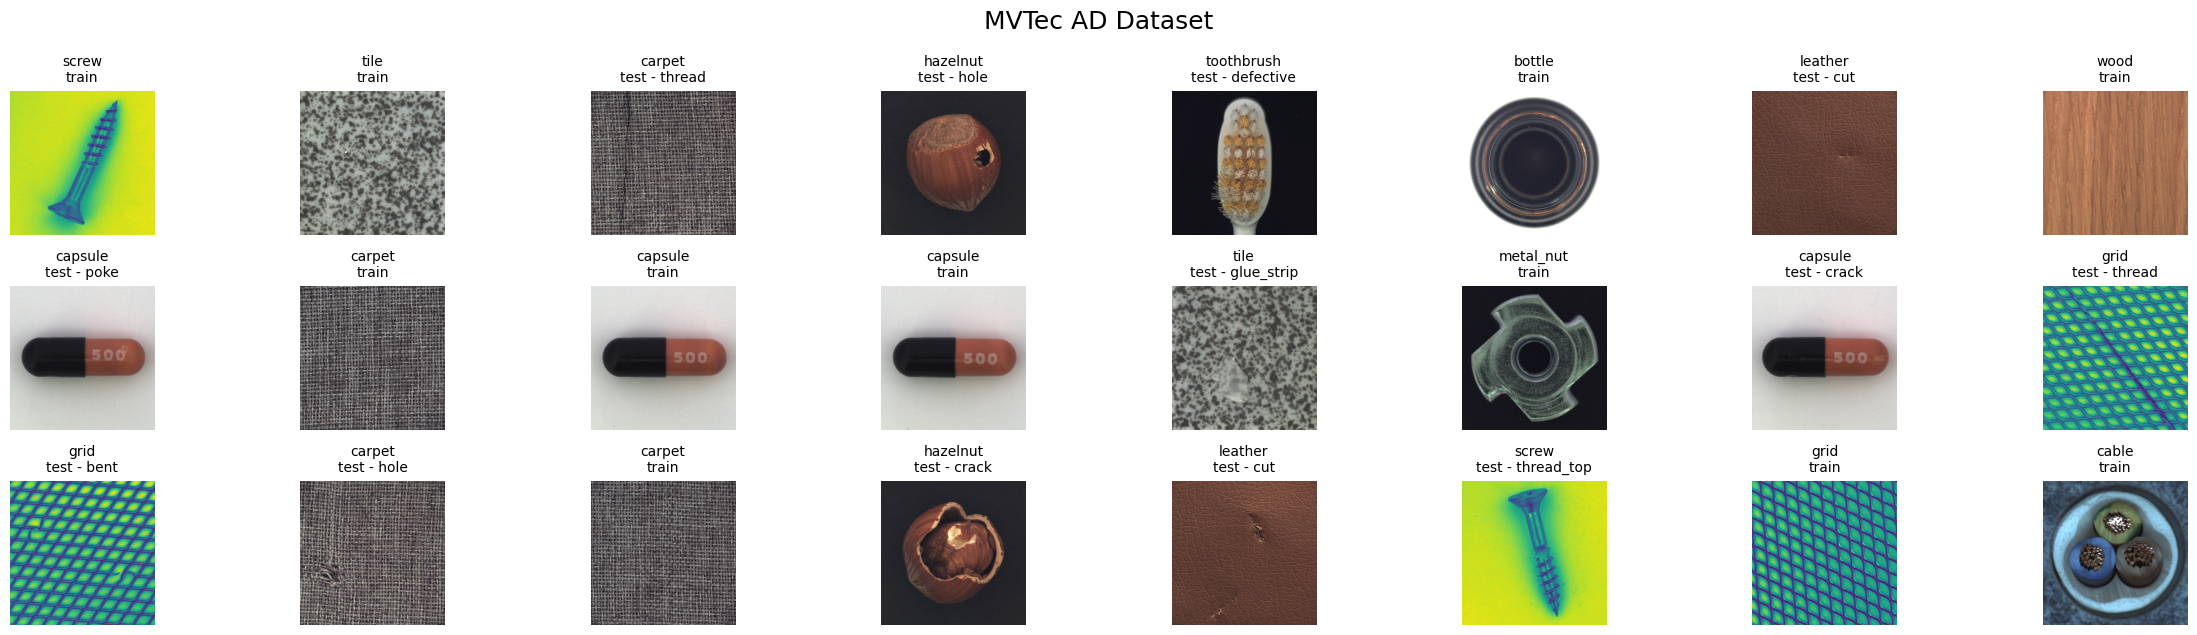

In [20]:
dataset_root = "/kaggle/input/mvtec-ad-dataset/mvtec_anomaly_detection/mvtec_anomaly_detection"

# All object categories
object_categories = sorted([
    d for d in os.listdir(dataset_root)
    if os.path.isdir(os.path.join(dataset_root, d))
])

# Initialize subplot
n_rows = 3
n_cols = 8
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6))

# Flatten axes for easy indexing
axes = axes.flatten()

# Collect 16 random images from various categories and subfolders
samples_collected = 0
max_samples = n_rows * n_cols

while samples_collected < max_samples:
    category = random.choice(object_categories)
    category_path = os.path.join(dataset_root, category)
    
    subfolder_type = random.choice(['train/good', 'test'])
    sub_path = os.path.join(category_path, subfolder_type)

    # For test folder, dive deeper into defect type
    if subfolder_type == 'test':
        defect_types = [f for f in os.listdir(sub_path)
                        if os.path.isdir(os.path.join(sub_path, f)) and f != 'good']
        if not defect_types:
            continue
        defect = random.choice(defect_types)
        sub_path = os.path.join(sub_path, defect)

    if not os.path.exists(sub_path):
        continue

    image_files = [f for f in os.listdir(sub_path) if f.endswith('.png')]
    if not image_files:
        continue

    img_file = random.choice(image_files)
    img_path = os.path.join(sub_path, img_file)

    # Load and plot
    try:
        img = Image.open(img_path)
        ax = axes[samples_collected]
        ax.imshow(img)
        label = f"{category}\n{subfolder_type.split('/')[0]}"
        if subfolder_type == 'test':
            label += f" - {defect}"
        ax.set_title(label, fontsize=10)
        ax.axis("off")
        samples_collected += 1
    except:
        continue

plt.tight_layout()
plt.suptitle("MVTec AD Dataset", fontsize=18, y=1.05)
plt.show()


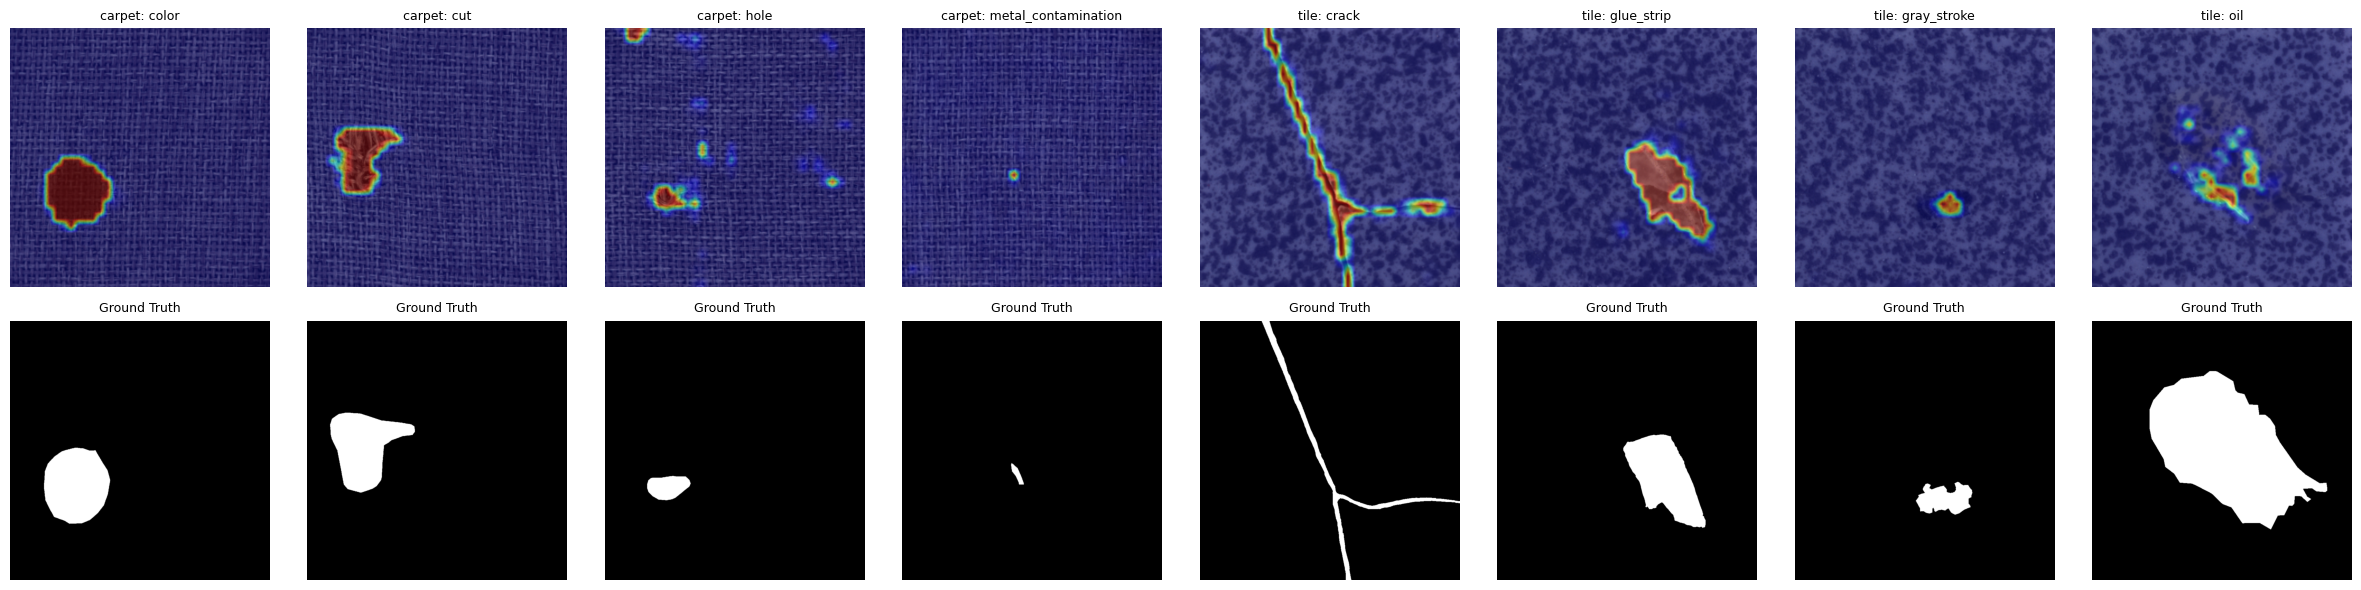

In [21]:
categories = {
    'tile': ["crack","glue_strip","gray_stroke","oil"],
    'carpet': ["color","cut","hole","metal_contamination"]
}

all_defects = categories['carpet'] + categories['tile']
n = len(all_defects)
fig, axes = plt.subplots(2, n, figsize=(3 * n, 6))
plt.subplots_adjust(hspace=0.4)

for i, defect in enumerate(all_defects):
    cls = 'carpet' if defect in categories['carpet'] else 'tile'

    img_dir = os.path.join(top_image_base, cls, defect)
    img_path = get_first_image(img_dir)

    gt_dir = os.path.join(gt_base, cls, "ground_truth", defect)
    gt_path = get_first_image(gt_dir)

    if img_path:
        img = Image.open(img_path).convert("RGB")
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"{cls}: {defect}", fontsize=9)
    else:
        axes[0, i].set_title(f"{cls}: {defect}\nNo Image", fontsize=9)
    axes[0, i].axis("off")

    if gt_path:
        gt = Image.open(gt_path).convert("RGB")
        axes[1, i].imshow(gt)
        axes[1, i].set_title("Ground Truth", fontsize=9)
    else:
        axes[1, i].set_title("No GT", fontsize=9)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()
